# Runaway robot

----------
Background

A robotics company named Trax has created a line of small self-driving robots 
designed to autonomously traverse desert environments in search of undiscovered
water deposits.

A Traxbot looks like a small tank. Each one is about half a meter long and drives
on two continuous metal tracks. In order to maneuver itself, a Traxbot can do one
of two things: it can drive in a straight line or it can turn. So to make a 
right turn, A Traxbot will drive forward, stop, turn 90 degrees, then continue
driving straight.

This series of questions involves the recovery of a rogue Traxbot. This bot has 
gotten lost somewhere in the desert and is now stuck driving in an almost-circle: it has
been repeatedly driving forward by some step size, stopping, turning a certain 
amount, and repeating this process... Luckily, the Traxbot is still sending all
of its sensor data back to headquarters.

In this project, we will start with a simple version of this problem and 
gradually add complexity. By the end, you will have a fully articulated
plan for recovering the lost Traxbot.

----------
Part One

Let's start by thinking about circular motion (well, really it's polygon motion
that is close to circular motion). Assume that Traxbot lives on 
an (x, y) coordinate plane and (for now) is sending you PERFECTLY ACCURATE sensor 
measurements. 

With a few measurements you should be able to figure out the step size and the 
turning angle that Traxbot is moving with.
With these two pieces of information, you should be able to 
write a function that can predict Traxbot's next location.

You can use the robot class that is already written to make your life easier. 
You should re-familiarize yourself with this class, since some of the details
have changed. 

----------
YOUR JOB

Complete the estimate_next_pos function. You will probably want to use
the OTHER variable to keep track of information about the runaway robot.

----------
GRADING

We will make repeated calls to your estimate_next_pos function. After
each call, we will compare your estimated position to the robot's true
position. As soon as you are within 0.01 stepsizes of the true position,
you will be marked correct and we will tell you how many steps it took
before your function successfully located the target bot.

In [1]:
# These import steps give you access to libraries which you may (or may
# not) want to use.
from robot import *
from math import *
from matrix import *
import random
import numpy as np
from kalman import Kalman
import matplotlib.pyplot as plt

In [2]:
# A helper function you may find useful.
def distance_between(point1, point2):
    """Computes distance between point1 and point2. Points are (x, y) pairs."""
    x1, y1 = point1
    x2, y2 = point2
    return sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

## Test function
Edited to add plotting functionality.

In [3]:
# This is here to give you a sense for how we will be running and grading
# your code. Note that the OTHER variable allows you to store any 
# information that you want. 
def demo_grading(estimate_next_pos_fcn, target_bot, max_iter=10, OTHER = None):
    localized = False
    distance_tolerance = 0.01 * target_bot.distance
    ctr = 0
    # if you haven't localized the target bot, make a guess about the next
    # position, then we move the bot and compare your guess to the true
    # next position. When you are close enough, we stop checking.

    pos_real_x = []
    pos_real_y = []
    pos_guess_x = []
    pos_guess_y = []

    while not localized and ctr <= max_iter: 
        ctr += 1
        measurement = target_bot.sense()
        position_guess, OTHER = estimate_next_pos_fcn(measurement, OTHER)
        target_bot.move_in_circle()
        true_position = (target_bot.x, target_bot.y)

        pos_real_x.append(true_position[0])
        pos_real_y.append(true_position[1])
        pos_guess_x.append(position_guess[0])
        pos_guess_y.append(position_guess[1])

        # print(f"True position:\n{true_position}")
        error = distance_between(position_guess, true_position)
        # print(f"Error: {error}")
        if error <= distance_tolerance:
            print("You got it right! It took you ", ctr, " steps to localize.")
            localized = True
        if ctr == max_iter:
            print("Sorry, it took you too many steps to localize the target.")

    plt.figure()
    plt.plot(pos_real_x, pos_real_y, 'green', label="true position")
    plt.plot(pos_guess_x, pos_real_y, 'red', label="estimated position")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Robot position")
    plt.ylim(-2, 20)

    print(f"Error: {error}")

    return localized

# This is a demo for what a strategy could look like. This one isn't very good.
def naive_next_pos(measurement, OTHER = None):
    """This strategy records the first reported position of the target and
    assumes that eventually the target bot will eventually return to that 
    position, so it always guesses that the first position will be the next."""
    if not OTHER: # this is the first measurement
        OTHER = measurement
    xy_estimate = OTHER 
    return xy_estimate, OTHER

# This is how we create a target bot. Check the robot.py file to understand
# How the robot class behaves.
test_target = robot(2.1, 4.3, 0.5, 2*pi / 34.0, 1.5)
test_target.set_noise(0.0, 0.0, 0.0)

## Attempt 1: Kalman filter
4D Kalman filter using x, y, dx and dy.

### Result
The model follows a curved path in the right direction, but seems to strongly overcorrect and doesn't correct back to make the curvature of the path smaller.

In [4]:
# This is the function you have to write. The argument 'measurement' is a 
# single (x, y) point. This function will have to be called multiple
# times before you have enough information to accurately predict the
# next position. The OTHER variable that your function returns will be 
# passed back to your function the next time it is called. You can use
# this to keep track of important information over time.
def estimate_next_pos(measurement, OTHER = None):
    """Estimate the next (x, y) position of the wandering Traxbot
    based on noisy (x, y) measurements."""

    if not OTHER:
        kalman = Kalman([measurement[0], measurement[1], 0, 0])
        loc = kalman.get_loc()

    else:
        kalman = OTHER
        loc = kalman.filter(measurement)

    # You must return xy_estimate (x, y), and OTHER (even if it is None) 
    # in this order for grading purposes.
    return (loc[0], loc[1]), kalman

Sorry, it took you too many steps to localize the target.
Error: 7.695276302513825


False

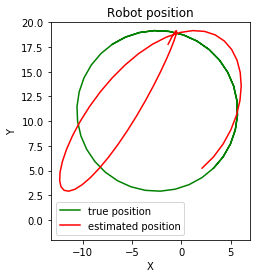

In [5]:
demo_grading(estimate_next_pos, test_target, max_iter=50)

## Attempt 2: extended Kalman filter
Extra derivative terms added to reduce overshoot / oversteering as seem in the simple Kalman filter.

### Result
Adding extra derivative terms improves the estimate, but only to a certain limit. The estimate converges to an elliptical path that doesn't match the path of the runaway robot.
Perhaps a linear model is not the most suitable way to estimate the path here.

In [6]:
# This is the function you have to write. The argument 'measurement' is a 
# single (x, y) point. This function will have to be called multiple
# times before you have enough information to accurately predict the
# next position. The OTHER variable that your function returns will be 
# passed back to your function the next time it is called. You can use
# this to keep track of important information over time.
def estimate_next_pos(measurement, OTHER = None):
    """Estimate the next (x, y) position of the wandering Traxbot
    based on noisy (x, y) measurements."""

    if not OTHER:
        kalman = Kalman([
            measurement[0], measurement[1], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        loc = kalman.get_loc()

    else:
        kalman = OTHER
        loc = kalman.filter(measurement)

    # You must return xy_estimate (x, y), and OTHER (even if it is None) 
    # in this order for grading purposes.
    return (loc[0], loc[1]), kalman

Sorry, it took you too many steps to localize the target.
Error: 1.7047637640107918


False

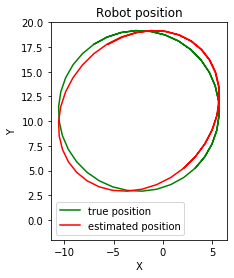

In [10]:
demo_grading(estimate_next_pos, test_target, max_iter=50)